# What happens at the change event?

In [1]:
# initialise:

%run /Users/etc/Projects/201612-lanl-analysis/LANL-analysis/0-lanl-init.ipynb

Let's focus on period of a few hours around the spike in process count to understand what's going on.

In [40]:
# the event sets for the critical period:

from __future__ import print_function

start_hour = 339
end_hour = 351

proc_chg = procs.filter(lambda x:  x[0]>3600*start_hour and x[0]<3600*end_hour)
flows_chg = flows.filter(lambda x: x[0]>3600*start_hour and x[0]<3600*end_hour)
dns_chg = dns.filter(lambda x:     x[0]>3600*start_hour and x[0]<3600*end_hour)

Plot time series for the three data sets in this period:

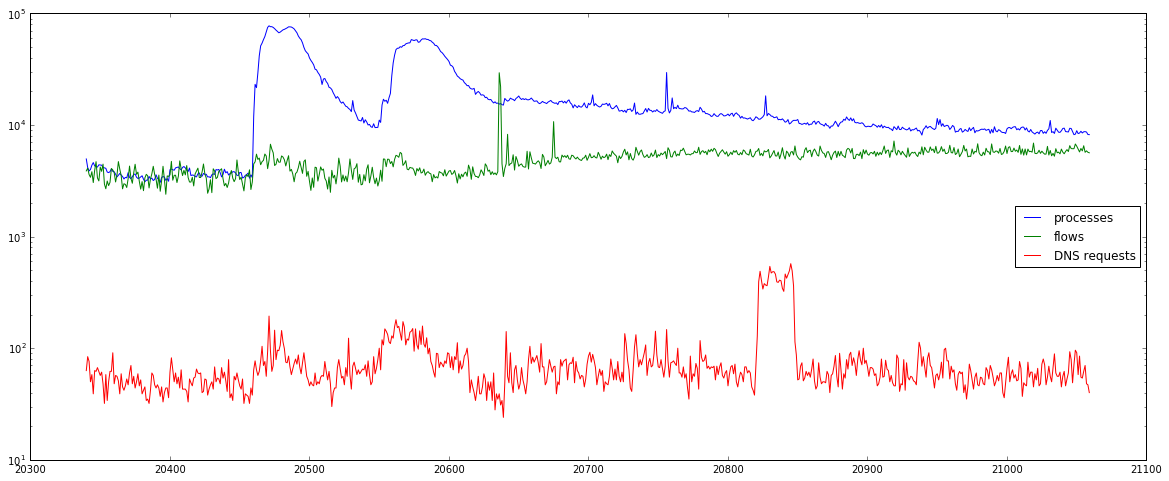

In [2]:
# the time series for this period at 1-minute resolution:

%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict

binsize = 60
proc_ts = proc_chg.map(lambda x: x[0]).map(lambda x: x/binsize).countByValue()
flow_ts = flows_chg.map(lambda x: x[0]).map(lambda x: x/binsize).countByValue()
dns_ts = dns_chg.map(lambda x: x[0]).map(lambda x: x/binsize).countByValue()

# these need to be sorted:
proc_ts = OrderedDict(sorted(proc_ts.items()))
flow_ts = OrderedDict(sorted(flow_ts.items()))
dns_ts = OrderedDict(sorted(dns_ts.items()))

# now plot:
plt.figure(figsize=(20,8))
ts1, = plt.semilogy(proc_ts.keys(), proc_ts.values(), label='processes')
ts2, = plt.semilogy(flow_ts.keys(), flow_ts.values(), label='flows')
ts3, = plt.semilogy(dns_ts.keys(), dns_ts.values(), label='DNS requests')
plt.legend(handles=[ts1, ts2, ts3], loc='center right')
plt.show()

Are the peaks the result of a single computer, or user, or process? Note the correlated double peaks in both the flows and DNS. We'll return to these later.

For the next sections we'll use some common map-reduce and plotting code for profiling the three data sets:

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

def mapper(x, ncol, binsize=60):
    """
    ncol = nr columns in table including timestamp
    """
    return (x[0]/binsize, x[1:ncol])

def reducer(dat, ncol, names=None):
    n = len(dat)
    if names == None: 
        names = ["col%d" % i for i in range(1,ncol)]
    out = {}
    for i in range(ncol-1):
        d = dict(Counter([x[i] for x in dat]))
        d_prob = max(d.values())/float(sum(d.values()))
        d_val = [k for (k,v) in d.items() if v == max(d.values())][0]
        out[names[i]] = [d_prob, d_val]
    return [n, out]

def compute_table_profile(rdd, ncol, names=None):
    """
    the map-reduce job:
    """ 
    ts_list = rdd.map(lambda x: mapper(x, ncol))\
                .groupByKey()\
                .map(lambda x : (x[0], reducer(list(x[1]), ncol, names=names)))\
                .collect()
    return dict(ts_list)

def plot_table_profile(ts_dict, names, threshold=0.5, overlay=False):
    x = sorted(ts_dict.keys())
    if overlay:
        plt.figure(figsize=(20,8))
        plt.ylim(ymin=0.0, ymax=1.0)
        plt.plot([min(x),max(x)], [threshold, threshold], color='grey', linestyle='dashed')
        handles = []
        for k in names:
            ts, = plt.plot(x, [ts_dict[t][1][k][0] for t in x], label=k)
            handles += [ts]
        plt.legend(handles=handles, loc='center right')
        plt.show()
        for k in names:
            dom_flow = Counter( [ts_dict[t][1][k][1] for t in x 
                                 if ts_dict[t][1][k][0] > threshold] )
            if len(dom_flow) > 0: 
                print("%s dominating by > %g: %s" % (k, threshold, dict(dom_flow)))
    else:
        for k in names:
            plt.figure(figsize=(20,5))
            plt.ylim(ymin=0.0, ymax=1.0)
            plt.plot([min(x),max(x)], [threshold, threshold], color='grey', linestyle='dashed')
            plt.plot(x, [ts_dict[t][1][k][0] for t in x])
            plt.title(k)
            plt.show()
            dom_flow = Counter( [ts_dict[t][1][k][1] for t in x 
                                 if ts_dict[t][1][k][0] > threshold] )
            if len(dom_flow) > 0: 
                print("%s dominating by > %g: %s" % (k, threshold, dict(dom_flow)))



# Processes

In [22]:
proc_chg.cache()

# how many process events in this period, and how many computers involved?
nr_cmps = proc_chg.map(lambda x: x[3]).distinct().count()

print("Period:", (end_hour - start_hour), "hours")
print("Nr process events:", proc_chg.count())
print("Nr computers:", nr_cmps)

Period: 12 hours
Nr process events: 11831486
Nr computers: 9316


Now call a map-reduce job to pull out time series to summarise the behaviour of the different fields in the processes data set, and then plot the results.

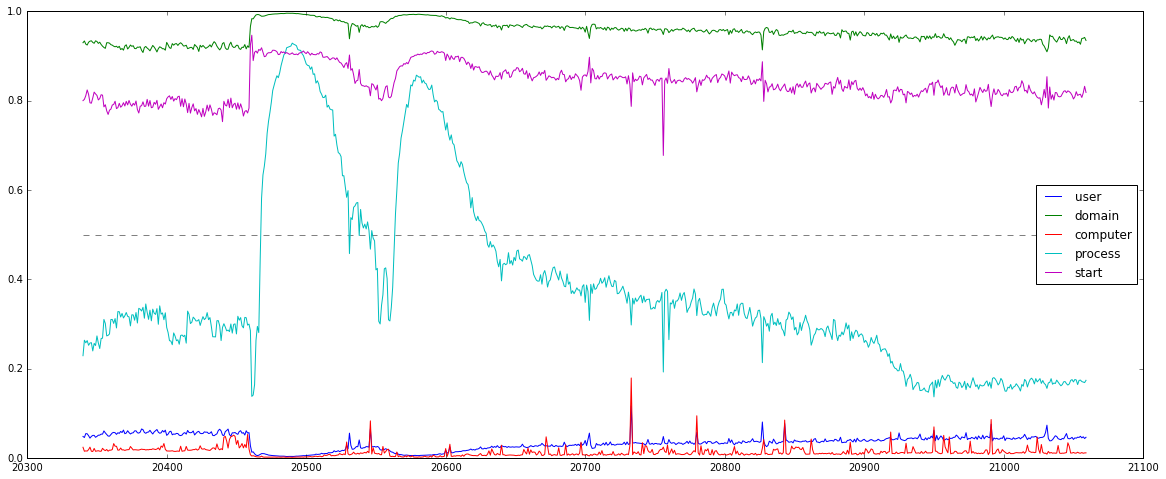

domain dominating by > 0.5: {'DOM1': 720}
process dominating by > 0.5: {'P265': 143}
start dominating by > 0.5: {'Start': 720}


In [37]:
names = ['user','domain','computer','process','start']

proc_ts_dict = compute_table_profile(proc_chg, 1+len(names), names=names)
plot_table_profile(proc_ts_dict, names, threshold=0.5, overlay=True)

What we see is that the key correlate of the spike in events is the red graph, which represents the dominance by process within time bins - that is, the proportion of events owned by the most numerous process. What this shows is that the spike is the result of a single process 'P265'.

In [38]:
proc_chg.unpersist()

PythonRDD[10] at RDD at PythonRDD.scala:43

# Flows

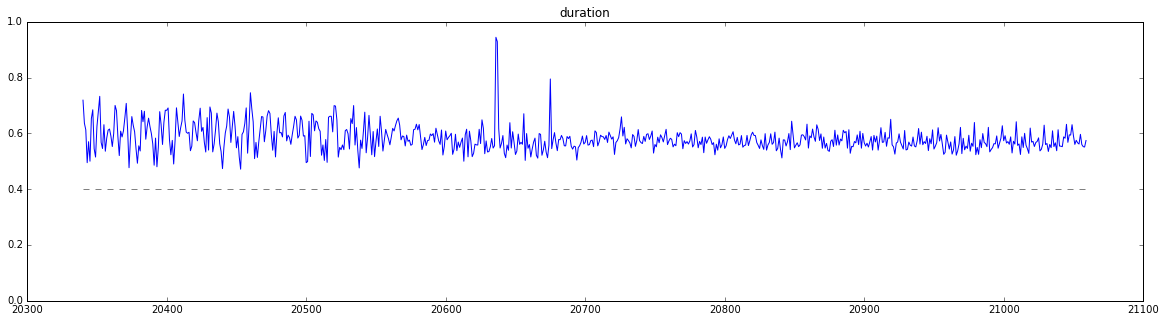

duration dominating by > 0.4: {0: 720}


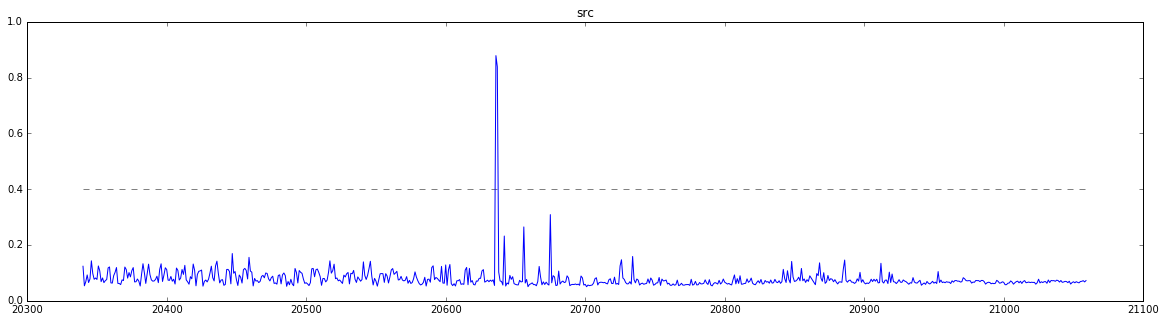

src dominating by > 0.4: {'C17160': 2}


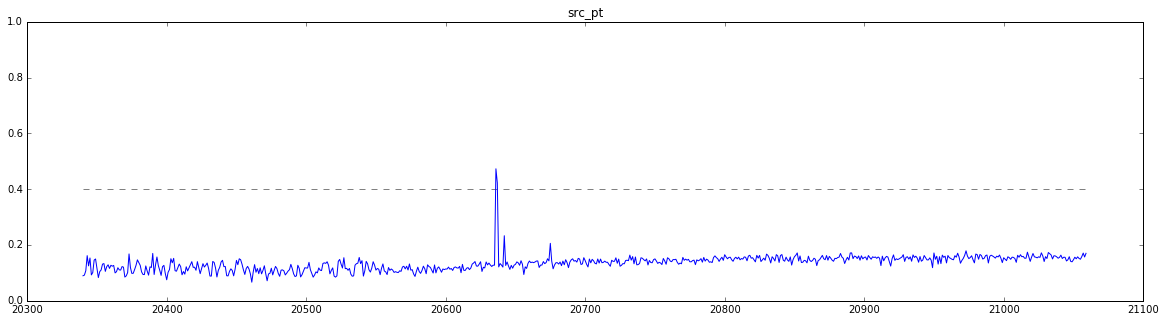

src_pt dominating by > 0.4: {'N13105': 2}


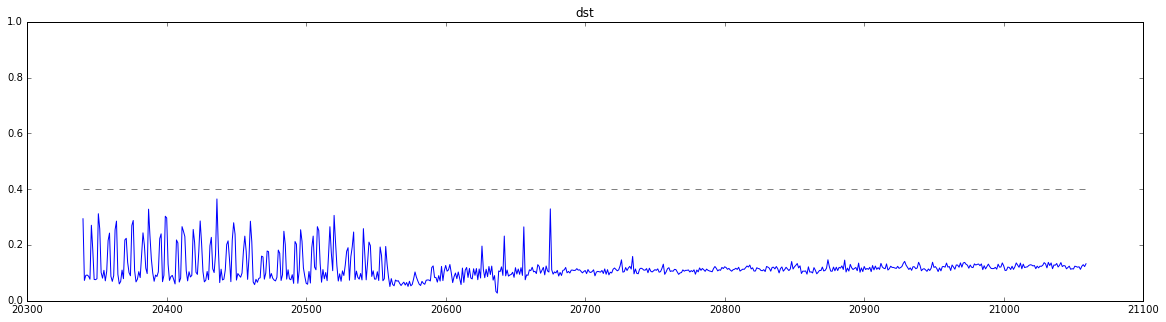

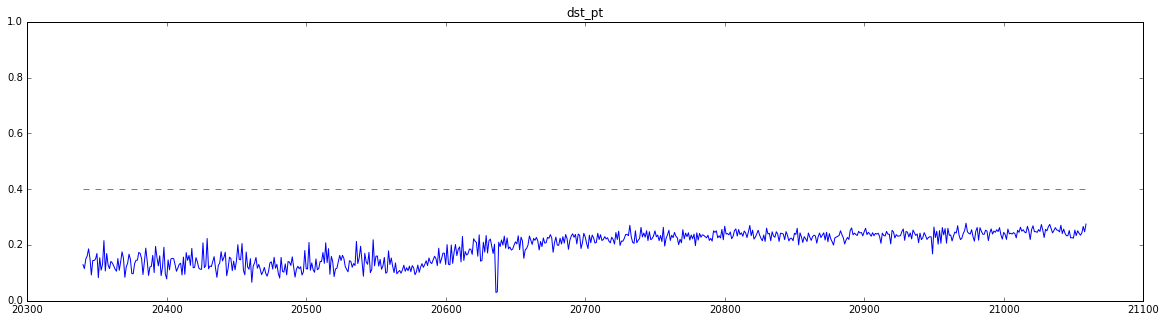

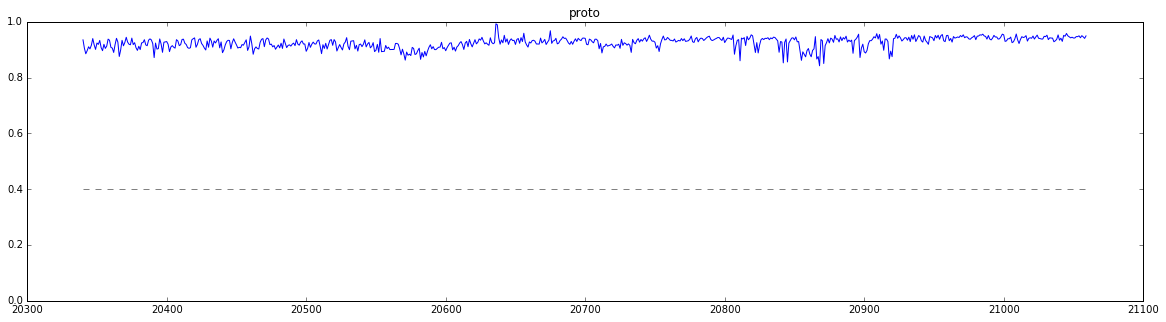

proto dominating by > 0.4: {6: 720}


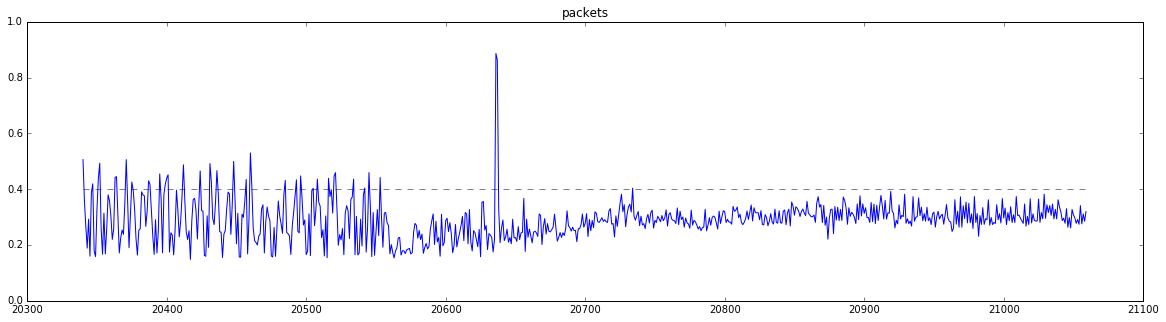

packets dominating by > 0.4: {1: 38}


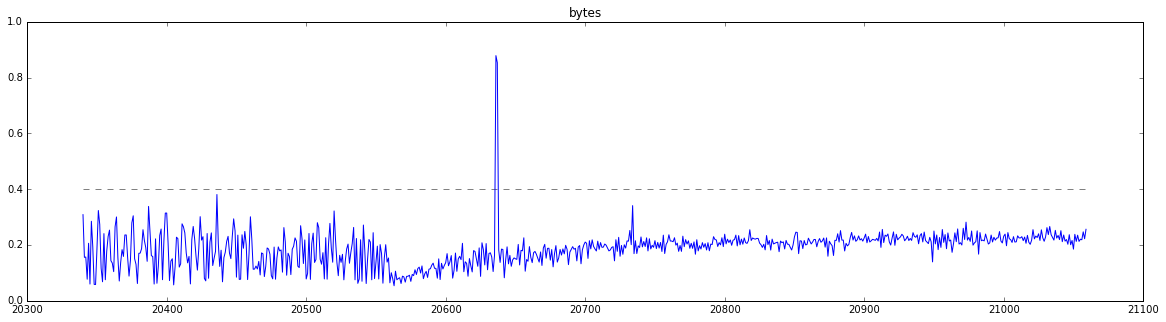

bytes dominating by > 0.4: {46: 2}


In [46]:
flows_chg.cache()

names = ['duration','src','src_pt','dst','dst_pt','proto','packets','bytes']
flow_ts_dict = compute_table_profile(flows_chg, 1+len(names), names=names)
plot_table_profile(flow_ts_dict, names, threshold=0.4, overlay=False)

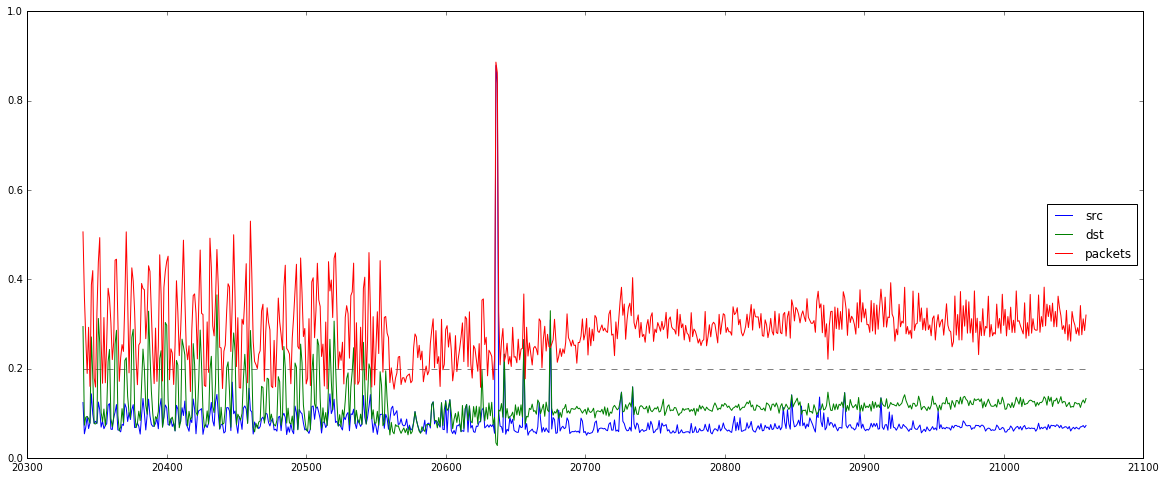

src dominating by > 0.2: {'C17160': 2, 'C1883': 1, 'C6055': 1, 'C5721': 1}
dst dominating by > 0.2: {'C1549': 54, 'C1883': 1, 'C5721': 1}
packets dominating by > 0.2: {1: 648, 6: 1}


In [48]:
names = ['src','dst','packets']
plot_table_profile(flow_ts_dict, names, threshold=0.2, overlay=True)

In [49]:
flows_chg.unpersist()

PythonRDD[49] at RDD at PythonRDD.scala:43

# DNS

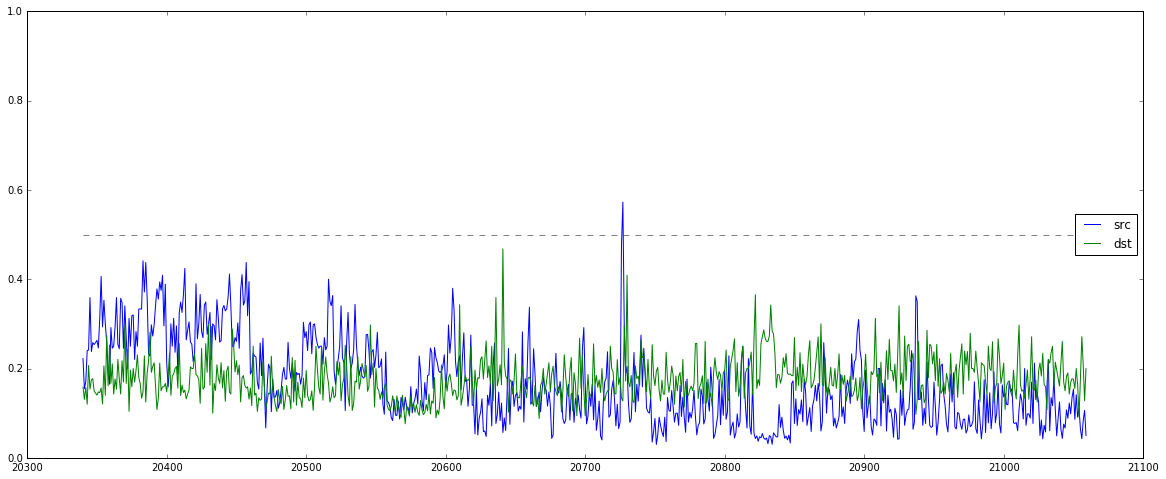

src dominating by > 0.5: {'C20722': 1}


In [53]:
dns_chg.cache()

names = ['src','dst']

dns_ts_dict = compute_table_profile(dns_chg, 1+len(names), names=names)
plot_table_profile(dns_ts_dict, names, threshold=0.5, overlay=True)

In [52]:
dns_chg.unpersist()

PythonRDD[50] at RDD at PythonRDD.scala:43

<h2>Conclusions</h2>

<ol>
<li> The change event consists of two peaks in the rate of Windows processes separated by ~2 hours;
<li> each peak is followed by a peak in DNS requests ~1 hour later (see later analysis);
<li> the peaks are the result of a single process P265 occupying 80-90% of the events.
</ol>

<h2>ADAP: profiling change points</h2>

What would automation of this part of the analysis look like? We did the following:

<ul>
<li> select a local time window around the change event - i.e. 'start_hour' and 'end_hour';
<li> select a time resolution (e.g. 60 second time bin size);
<li> for each data column (user, computer etc) compute, in each time bin, the distribution of values in that column;
<li> report, in each time bin, the modal probability;
<li> look for columns in which the modal probability stays above 50% - i.e. for which the bin is dominated by a single value.
</ul>

Can ADAP assess change points similarly? That is, zoom in locally and investigate the time evolution of the value distribution for each column in the data.